In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.io import make_dataloader, collate_fn_basic

from stack_segmentation.training import (
    handle_stacks_data, 
    make_optimization_task, 
    train_loop
)

from stack_segmentation.pipeline_config import (
    dataloaders_conf,
    train_conf,
    model_config, 
    aug_config,
    optimizer_config,
    loss_config,
    scheduler_config,
)

In [6]:
from exp_config import data_conf

## Parameters to tune

In [7]:
train_conf['device'] = 'cuda:1'
# train_conf['device'] = 'cpu'
train_conf['num_epochs'] = 500
train_conf

{'num_epochs': 500, 'device': 'cuda:1'}

In [8]:
data_conf['conf_name'] = 'exp_basic_adamw_lr5e-3_epoch_300_resnet18_encoder_soft_aug_k_1_weight10_patch64_bs_32'
data_conf['patches'] = {
    'train': (64, 64, 1),
    'val': (64, 64, 1),
    'test': (64, 64, 1)
}
data_conf

{'conf_name': 'exp_basic_adamw_lr5e-3_epoch_300_resnet18_encoder_soft_aug_k_1_weight10_patch64_bs_32',
 'stacks': [{'path': '../../data/carb96558',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(250, 470, None))},
  {'path': '../../data/SoilB-2',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(240, 460, None))},
  {'path': '../../data/Urna_22',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 220, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(245, 455, None))},
  {'path': '../../data/carb96558',
   'slice_test': (slice(None, None, None),
    slice(None, None, None),
    slice(490, None, None))},
  {'path': '../../data/carb71',
   'slice_t

In [13]:
model_config['encoder_name'] = 'resnet18'
model_config

{'source': 'qubvel',
 'model_type': 'Unet',
 'encoder_name': 'resnet18',
 'encoder_weights': 'imagenet'}

In [14]:
optimizer_config['opt_type'] = 'AdamW'
optimizer_config['lr'] = 5e-3
optimizer_config['weight_decay'] = 5e-5
optimizer_config['amsgrad'] = True
# optimizer_config['nesterov'] = True
optimizer_config

{'opt_type': 'AdamW',
 'lr': 0.005,
 'weight_decay': 5e-05,
 'amsgrad': True,
 'nesterov': False,
 'momentum': 0.9,
 'centered': False}

In [15]:
aug_config['aug_type'] = 'soft'
aug_config['k'] = 1
aug_config['original_height'] = 64
aug_config['original_width'] = 64
aug_config

{'aug_type': 'soft', 'original_height': 64, 'original_width': 64, 'k': 1}

In [16]:
loss_config =[
    {
        'loss': 'BCE', 
        'weight': 1, 
        'params': {'weight': [1, 10]}},
    {
        'loss': 'Dice',
        'weight': 2, 
        'params': {
            'mode': 'multiclass',
            'classes': [1], # может быть, этот параметр не нужен
            'log_loss': True,
            'from_logits': True,
            'smooth': 1,
            'eps': 1e-7
        }
    }
]
loss_config

[{'loss': 'BCE', 'weight': 1, 'params': {'weight': [1, 10]}},
 {'loss': 'Dice',
  'weight': 2,
  'params': {'mode': 'multiclass',
   'classes': [1],
   'log_loss': True,
   'from_logits': True,
   'smooth': 1,
   'eps': 1e-07}}]

In [17]:
dataloaders_conf['train']['batch_size'] = 32
dataloaders_conf['val']['batch_size'] = 32
dataloaders_conf['test']['batch_size'] = 32
dataloaders_conf

{'train': {'batch_size': 32, 'num_workers': 16, 'shuffle': True},
 'val': {'batch_size': 32, 'num_workers': 16, 'shuffle': False},
 'test': {'batch_size': 32, 'num_workers': 16, 'shuffle': True}}

## Prepare train, validation and test data

In [18]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:00, 729.61it/s]
100%|██████████| 720/720 [00:07<00:00, 96.66it/s] 
33120it [00:00, 147116.97it/s]
31680it [00:00, 237221.43it/s]
700it [00:00, 785.56it/s]
100%|██████████| 700/700 [00:06<00:00, 103.08it/s]
27830it [00:00, 128519.96it/s]
26620it [00:00, 117236.59it/s]
710it [00:00, 776.69it/s]
100%|██████████| 710/710 [00:07<00:00, 99.28it/s] 
31680it [00:00, 244687.88it/s]
30240it [00:00, 116655.79it/s]
720it [00:00, 837.61it/s]
100%|██████████| 720/720 [00:06<00:00, 104.07it/s]
33120it [00:00, 242295.62it/s]
720it [00:00, 821.58it/s]
100%|██████████| 720/720 [00:07<00:00, 95.64it/s] 
103680it [00:00, 169710.47it/s]
700it [00:00, 856.62it/s]
100%|██████████| 700/700 [00:06<00:00, 102.97it/s]
84700it [00:00, 148240.41it/s]
509it [00:00, 1189.88it/s]
100%|██████████| 509/509 [00:02<00:00, 196.54it/s]
32576it [00:00, 83452.37it/s] 
700it [00:00, 843.64it/s]
100%|██████████| 700/700 [00:06<00:00, 102.38it/s]
84700it [00:00, 220941.89it/s]
700it [00:00, 824.68it/s]
100%|██████████

In [19]:
len(data_train), len(data_val), len(data_test)

(92630, 88540, 11)

In [20]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    aug_config=aug_config,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        model_config=model_config,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [21]:
device = 'cuda:1'
# device = 'cpu'

In [22]:
model, criterion, optimizer, scheduler = make_optimization_task(
    device,
    model_config=model_config,
    loss_config=loss_config, 
    optimizer_config=optimizer_config,
    scheduler_config=scheduler_config)

## Run experiment

In [23]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [24]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [ ]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    es_patience=20,
    **train_conf)

  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 0...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.046362


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.031355
Epoch 1...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.029901


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.027087
Epoch 2...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.027567


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.026152
Epoch 3...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.026157


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.025125
Epoch 4...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.025417


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.025329
EarlyStopping counter: 1 out of 20
Epoch 5...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.025185


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.023993
Epoch 6...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.024673


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.023659
Epoch 7...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.02405


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.025423
EarlyStopping counter: 1 out of 20
Epoch 8...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.023814


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.023574
Epoch 9...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.023521


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.023041
Epoch 10...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.023303


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.027999
EarlyStopping counter: 1 out of 20
Epoch 11...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.023086


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.024358
EarlyStopping counter: 2 out of 20
Epoch 12...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.022954


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022884
Epoch 13...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.022782


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.03225
EarlyStopping counter: 1 out of 20
Epoch 14...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.022726


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.028458
EarlyStopping counter: 2 out of 20
Epoch 15...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.022872


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.03547
EarlyStopping counter: 3 out of 20
Epoch 16...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.022497


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.026433
EarlyStopping counter: 4 out of 20
Epoch 17...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.022365


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.02624
EarlyStopping counter: 5 out of 20
Epoch 18...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.022195


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022277
Epoch 19...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.022121


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.034993
EarlyStopping counter: 1 out of 20
Epoch 20...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.022018


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022828
EarlyStopping counter: 2 out of 20
Epoch 21...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.02203


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.026737
EarlyStopping counter: 3 out of 20
Epoch 22...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021875


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.024641
EarlyStopping counter: 4 out of 20
Epoch 23...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021861


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.026738
EarlyStopping counter: 5 out of 20
Epoch 24...


 39%|███▊      | 1115/2895 [00:42<01:07, 26.38it/s]

## Dump experiment results

In [44]:
import pickle
import json

In [45]:
p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
with open(p, 'wb') as f:
    pickle.dump(results, f)

In [28]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'rb') as f:
#     results = pickle.load(f)

In [11]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Train and validation losses

In [46]:
from itertools import chain

In [47]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [48]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

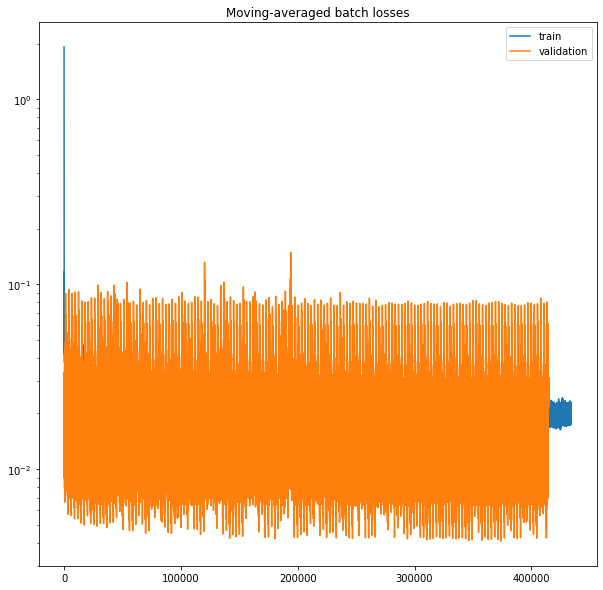

In [49]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [50]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

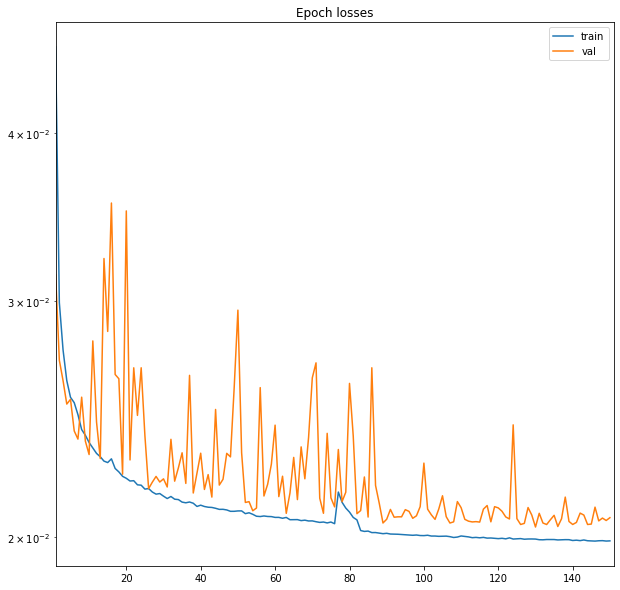

In [51]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Results

In [52]:
import pandas as pd

In [53]:
from visualization_utils import make_df

In [54]:
df = make_df(results, model_name='basic')
df

,accuracy,precision,recall,f1,pr_auc,iou,stack,model
0,0.996216,0.952222,0.995854,0.973549,0.998578,0.948462,carb96558,basic
1,0.986214,0.914905,0.997034,0.954206,0.989521,0.912422,carb71,basic
2,0.984453,0.890049,0.940481,0.914570,0.975006,0.842589,carbRNF,basic
3,0.992249,0.991210,0.949810,0.970068,0.997849,0.941876,SPE_carb10_58_box3,basic
4,0.990731,0.954932,0.956446,0.955688,0.994120,0.915137,SoilAh-1,basic
5,0.995100,0.911153,0.991584,0.949669,0.996377,0.904161,SoilB-2,basic
6,0.992027,0.994289,0.939082,0.965898,0.994961,0.934044,TeTree_subset1,basic
7,0.994965,0.991456,0.954475,0.972614,0.995757,0.946688,TiTree_subset2,basic
8,0.992645,0.946364,0.997616,0.971315,0.998339,0.944229,Urna_22,basic
9,0.990738,0.960498,0.987085,0.973610,0.998075,0.948577,Urna_30,basic


In [55]:
print('Mean   IOU: {:.5}'.format(df['iou'].mean()))
print('Std    IOU: {:.5}'.format(df['iou'].std()))
print('Min    IOU: {:.5}'.format(df['iou'].min()))
print('Median IOU: {:.5}'.format(df['iou'].median()))

Mean   IOU: 0.92304
Std    IOU: 0.031381
Min    IOU: 0.84259
Median IOU: 0.93404


## Check loss to loss ratio

In [56]:
criterion.losses

(WeightedLoss(
   (loss): CrossEntropyLoss()
 ), WeightedLoss(
   (loss): DiceLoss()
 ))

In [57]:
from stack_segmentation.training import make_joint_loss

In [58]:
import torch

In [59]:
# loss_config[0] = {'loss': 'BCE',
#   'weight': 0.5,
#   'params': {}}
# loss_config
# crit = make_joint_loss(device=device, loss_config=loss_config)

In [60]:
crit = criterion
a = []
b = []
for i, (x, y) in enumerate(dataloader_val):
    if i > 100:
        break
    pred = model(torch.from_numpy(x).to(device))
    y = torch.from_numpy(y).to(device)
    a.append(crit.losses[0](pred, y).cpu().data.numpy())
    b.append(crit.losses[1](pred, y).cpu().data.numpy())

In [61]:
print('Mean 0 loss: {:.4f}\nMean 1 loss: {:.4f}\nMean of ratios: {:.4f}\nRatio of means: {:.4f}'
      .format(np.mean(a), np.mean(b), np.mean(np.array(a) / np.array(b)), np.mean(a) / np.mean(b)))

Mean 0 loss: 0.0087
Mean 1 loss: 0.0041
Mean of ratios: 2.4449
Ratio of means: 2.1073
